In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-swing-on-ball.csv")

df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# all_files = glob.glob("roll_data/*-swing-on-strike.csv")

# df_strikes = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [1037]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]# * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]# * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]# * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2/freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

def get_pitcher_mul(row):
    bm = str(row["batter_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
            #mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #mul += min(0.05, 0.05 * (row["day"] / 99))
        pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul

def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
#         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        pass
    return mul

In [994]:
# additions and corrections, global

df_balls["batter_mul"] = df_balls.apply(get_batter_mul, axis=1)
df_balls["pitcher_mul"] = df_balls.apply(get_pitcher_mul, axis=1)

df_balls.loc[df_balls["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df_balls.loc[df_balls["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

df_balls["ruth_scaled"] = df_balls["pitcher_ruthlessness"] * df_balls["pitcher_mul"]
df_balls["mox_scaled"] = df_balls["batter_moxie"] * df_balls["batter_mul"]


df_balls['invpath'] = 1 - df_balls['batter_patheticism']
df_balls["invpath_scaled"] = 1 - df_balls["batter_patheticism"] * df_balls["batter_mul"]
df_balls["path_scaled"] = 1 - ((1 - df_balls["batter_patheticism"]) * df_balls["batter_mul"])
# df_balls["mox_path"] = df_balls["mox_scaled"] - df_balls["path_scaled"]
# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [995]:
# df = df[(df["batting_team_hype"] == 0) & (df['pitching_team_hype'] == 0)]

# df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * (1 + 0.2 * df_balls["pitcher_vibes"])
# df_balls["mox_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["mox_vibes"] = df_balls["mox_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

df_balls["invpath_vibes"] = df_balls["invpath-scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# beiju's idea
df_balls["visc_filth"] = df_balls["ballpark_viscosity"] * df_balls["ballpark_filthiness"]
# # put in our "best fit" up here in the original df, just because
# df['svc_best'] = 0.30 * df["ruth_scaled"] + 0.20 * df["ballpark_forwardness"] \
#                   + 0.06 * df["ruth_vibes"] + 0.10 * df["musc_scaled"]

df_balls['ruth_times_vibes'] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls['mox_times_vibes'] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls['path_times_vibes'] = df_balls["path_scaled"] * df_balls["batter_vibes"]


# kidror's idea
df_balls["ruth_sq"] = df_balls["ruth_vibes"]**2
df_balls["mox_sq"] = df_balls["mox_vibes"]**2
# df_balls["path_sq"] = df_balls["path_scaled"]**2 # not path_vibes
df_balls["visc_sq"] = df_balls["ballpark_viscosity"]**2

In [996]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]

# just look at swinging on balls first
dfc = df_balls
for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH",
                    "SINKING_SHIP", "TRAVELING", "AFFINITY_FOR_CROWS", "CHUNKY", "SMOOTH", "ON_FIRE"]:
# for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    # exclude flinch situations entirely...superfluous i think, it doesn't roll when flinching
    dfc = dfc[~((dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0))]

In [997]:
# print(list(df_balls.columns))
print(len(df_balls))
print(len(dfc))

57959
34628


In [998]:
digest_list = ["event_type", "roll", "batter_name", "pitcher_name",
               "ruth_scaled", "pitcher_vibes", "musc_scaled",
               "ballpark_forwardness", "game_id", "play_count", "svc_best"]

In [999]:
# print(coef_list, intercept_scaled)
# print(X.columns)

In [1000]:
dfc[dfc["passed"] == True]["roll"].max()

0.9492693003761858

In [1001]:
dfc[dfc["passed"] == False]["roll"].min()

0.0022923664988039

In [1002]:
# max for swings seems to be 0.95 so remove rolls above that
dfc = dfc[dfc['roll'] < 0.95]
# weird "cutoff" at 0.1 (though you can take pitches below this!) so remove rolls below that
dfc = dfc[dfc['roll'] > 0.1]
len(dfc)

29545

[0.04783582 0.70462381 0.38767944]


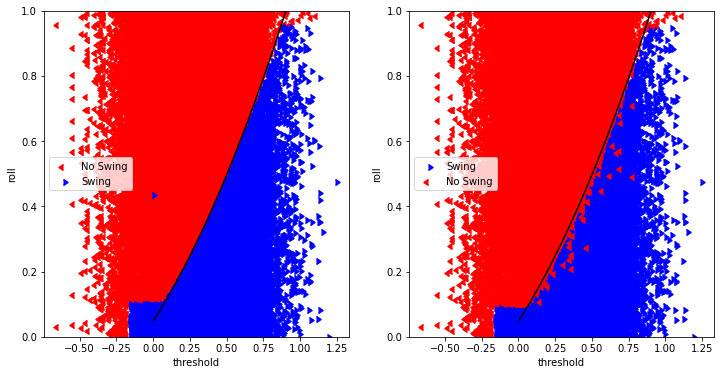

In [1020]:
# df_balls["threshold"] = -1*(\
#     -0.10 + \
#     -0.65 * df_balls["ruth_vibes"] + \
#     0.27 * df_balls["mox_vibes"] + \
#     0.27 * df_balls["invpath_scaled"] + \
#     -0.20 * df_balls["ballpark_viscosity"])

# dfc["threshold"] = -1*(\
#     -0.10 + \
#     -0.65 * df_balls["ruth_vibes"] + \
#     0.27 * df_balls["mox_vibes"] + \
#     0.27 * df_balls["invpath_scaled"] + \
#     -0.20 * df_balls["ballpark_viscosity"])


# x_val = "ruth_vibes"
x_val = "threshold"

y_val = df_balls
# y_val = dfc

polycoefs = (series_s.convert().coef + series_l.convert().coef)/2
print(polycoefs)
linex = np.linspace(0,1,100)
fig, ax = plt.subplots(1, 2, figsize=(12,6))
for axN in ax:
    if axN == ax[0]:
        axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
        axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
    else:
        axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
        axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
    axN.plot(linex, polycoefs[0] + polycoefs[1]*linex + polycoefs[2]*linex**2, 'k')
    # ax.plot(np.linspace(0,1,100), series_s(np.linspace(0,1,100)), 'k')
    # xline = np.array(ax.get_xlim())
    # yline = -intercept_scaled + xline
    # # yline = -0.2 + xline
    # ax.plot(xline, yline, 'k')

    axN.set_xlabel(x_val)
    axN.set_ylabel('roll')
    axN.set_ylim(0, 1)
    # ax.set_yscale('log')
    # ax.set_xlim(0.484, 0.499)

    axN.legend()

# fig.savefig(x_val+".png", facecolor='white')

In [1004]:
dfc.groupby('batter_mul').head(1)[['batter_mul', 'batter_name']].sort_values(
    'batter_mul', ascending=False)[0:10]


,batter_mul,batter_name
0,1.0,Farrell Seagull


In [1005]:
print(list(df_balls.columns))

['Unnamed: 0', 'event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_contin

In [1006]:
# X = dfc[['roll', *dfc.columns[5:-11]]].drop('pitcher_name', axis=1).drop('batter_mods', axis=1)\
#     .drop('batting_team_mods', axis=1).drop('pitching_team_mods', axis=1).drop('pitcher_mods', axis=1)\
#     .drop('batter_vibes', axis=1).drop('pitcher_vibes', axis=1)\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness', 'pitcher_vibes_multiplied', 'batter_musclitude']]

# X = dfc[['roll', *dfc.columns[4:-42], 'batter_vibes', 'pitcher_vibes']]\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'ruth_vibes', 'path_vibes', 'mox_vibes', 'ballpark_viscosity']]#, 'mox_path', 'visc_filth']]
# X = dfc[['passed', 'roll', 'ruth_scaled', 'ballpark_forwardness', 'ruth_vibes', 'musc_scaled', 'flinch']]
# X = X[X['roll'] < 0.85]
X = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled', 'ballpark_viscosity']]

# X = dfc[['roll',
# #          'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 
#          'mox_scaled', 
# #          'batter_musclitude', 
# #          'invpath',
#          'path_scaled',# 'batter_thwackability','batter_tragicness',
# #          'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability',
# #          'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness',
# #          'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness',
# #          'batter_pressurization', 'batter_cinnamon', 'batter_multiplier',
# #          'batter_vibes',
#          'mox_times_vibes',
#          'path_times_vibes',
# #          'pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness',
#          'ruth_scaled',# 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness',
# #          'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness',
# #          'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness',
# #          'pitcher_pressurization', 'pitcher_cinnamon', 'pitcher_multiplier',
# #          'pitcher_vibes',
#          'ruth_times_vibes',
# #          'defense_avg_anticapitalism', 'defense_avg_chasiness', 'defense_avg_omniscience', 'defense_avg_tenaciousness', 'defense_avg_watchfulness',
# #          'ballpark_grandiosity', 'ballpark_fortification', 'ballpark_obtuseness', 'ballpark_ominousness', 'ballpark_inconvenience', 
#          'ballpark_viscosity'#, 'ballpark_forwardness', 'ballpark_mysticism', 'ballpark_elongation'
#         ]]
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = dfc['passed']
# X = X.drop('passed', axis=1)

In [1007]:
X

,roll,ruth_vibes,mox_vibes,invpath_scaled,ballpark_viscosity
0,0.134451,0.786526,1.011165,0.999000,0.263230
6,0.679864,0.786526,1.011165,0.999000,0.263230
8,0.614558,0.377605,0.404359,0.256128,0.481398
9,0.681459,0.786526,1.011165,0.999000,0.263230
10,0.185785,0.999588,0.789592,0.719674,0.432771
...,...,...,...,...,...
57855,0.280522,0.813605,1.293796,0.478432,0.496203
57857,0.816519,0.813605,0.473597,0.612314,0.496203
57858,0.514811,0.813605,0.473597,0.612314,0.496203
57860,0.191693,0.813605,0.926786,0.839000,0.496203


In [1008]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))

[[22169   161]
 [  169  7046]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     22330
        True       0.98      0.98      0.98      7215

    accuracy                           0.99     29545
   macro avg       0.99      0.98      0.98     29545
weighted avg       0.99      0.99      0.99     29545



In [1009]:
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)

0.9888305973938061

In [1010]:
coef = np.true_divide(trainedsvm.coef_,  sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

In [1011]:
# top6 = sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)[0:6]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)#[0:6]

[(1.0, 'roll'),
 (-0.6493800663604213, 'ruth_vibes'),
 (0.27074297728503866, 'invpath_scaled'),
 (0.26680261578837383, 'mox_vibes'),
 (-0.2178580998442088, 'ballpark_viscosity')]

In [1012]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.09413326])

In [1013]:
# factors = []
# for factor in top6:
#     factors.append(factor[1])
# factors
print(X.columns)
# print(X.columns[6] + '/' + X.columns[5] + ':', coef_list[6]/coef_list[5])
# print(X.columns[3] + '/' + X.columns[1] + ':', coef_list[3]/coef_list[1])
# print(X.columns[4] + '/' + X.columns[2] + ':', coef_list[4]/coef_list[2])
# coef_list

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity'],
      dtype='object')


In [1014]:
# dfc["threshold"] = -1*(\
#     intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_vibes"] + \
#     coef_scaled[0,2] * dfc["mox_vibes"] + \
#     coef_scaled[0,3] * dfc["invpath_scaled"] + \
#     coef_scaled[0,4] * dfc["ballpark_viscosity"])

dfc["threshold"] = -1*(\
    -0.10 + \
    -0.65 * df_balls["ruth_vibes"] + \
    0.27 * df_balls["mox_vibes"] + \
    0.27 * df_balls["invpath_scaled"] + \
    -0.20 * df_balls["ballpark_viscosity"])


dfc['threshold'] = -intercept_scaled[0]
df_balls['threshold'] = -intercept_scaled[0]
for pair in zip(coef_list, X.columns):
    if pair[1] != "roll":
        dfc['threshold'] -= pair[0] * dfc[pair[1]]
        df_balls['threshold'] -= pair[0] * df_balls[pair[1]]
# dfc["svc"] = \
#     0.5 * dfc["ruth_vibes"] + \
#     -0.25 * dfc["mox_vibes"] + \
#     0.25 * dfc["path_scaled"] + \
#     0.2 * dfc["ballpark_viscosity"] + \
#     0.10 * dfc["ruth_sq"]

1361


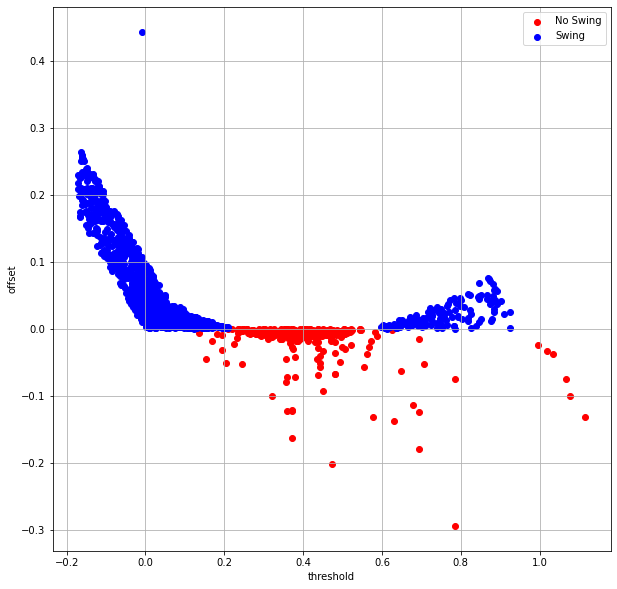

In [1015]:
# dfc["threshold"] = -1*(\
#     1.00 * 0.175 + \
#     -0.65 * dfc["ruth_vibes"] + \
#     -0.27 * dfc["path_scaled"] + \
#     0.27 * dfc["mox_scaled"] + \
#     -0.20 * dfc["ballpark_viscosity"] + \
#     0.04 * dfc["mox_vibes"] + \
#     0.008 * dfc["path_vibes"])
# dfc["threshold"] = dfc["svc"] - 0.125
# dfc["threshold"] = dfc["svc"] - intercept_scaled
# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95


dfc["offset"] = dfc["roll"] - dfc["threshold"]
df_balls["offset"] = df_balls["roll"] - df_balls["threshold"]

outliers = df_balls.copy()[(df_balls["passed"] & (df_balls["offset"] > 0)) | (~df_balls["passed"] & (df_balls["offset"] < 0))]
# outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

print(len(outliers))

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
x_val = "threshold"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="No Swing")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Swing")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.grid()
ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
fig.savefig("swing_fit_outliers.png", facecolor='white')

In [1040]:
col_list = ['event_type',
            'roll',
            'threshold',
            'offset',
            'batter_moxie',
            'batter_patheticism',
            'pitcher_ruthlessness',
            'batter_vibes',
            'pitcher_vibes',
            'mox_vibes',
            'path_vibes',
            'ruth_vibes',
            'batter_mul',
            'pitcher_mul',
            'ballpark_viscosity',
            'ballpark_forwardness',
            'batter_musclitude',
            'batter_name',
            'pitcher_name',
            'game_id',
            'play_count',
            'batter_mods',
            'pitcher_mods',
            'batting_team_mods',
            'pitching_team_mods',
            'weather',
            'day',
            'game_id',
            'play_count']
outliers.sort_values('offset', ascending=False).loc[:, col_list]

,event_type,roll,threshold,offset,batter_moxie,batter_patheticism,pitcher_ruthlessness,batter_vibes,pitcher_vibes,mox_vibes,...,game_id,play_count,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,weather,day,game_id,play_count
24214,Out,0.434916,-0.007818,0.442735,0.645117,0.050000,0.555879,0.217382,0.409479,1.346328,...,475a6c72-bb27-437d-9779-aacd0be2acbe,264,ALTERNATE;CHUNKY,ALTERNATE,BASE_INSTINCTS,LIFE_OF_PARTY;ELECTRIC,10,13,475a6c72-bb27-437d-9779-aacd0be2acbe,264
56084,StrikeSwinging,0.099723,-0.164006,0.263729,1.181096,0.367858,0.232161,0.076364,-0.170581,1.199135,...,e5229a96-dfb7-4ce2-a610-3e92f688e092,286,NaN,FRIEND_OF_CROWS,NaN,GROWTH,13,101,e5229a96-dfb7-4ce2-a610-3e92f688e092,286
15271,Foul,0.097619,-0.161847,0.259465,1.099834,0.490344,0.104391,0.172333,-0.131032,1.137742,...,0b4a26a8-46d3-4d2c-a6eb-5e1d3682f1df,145,NaN,NaN,HIGH_PRESSURE,TRAVELING;PARTY_TIME,1,96,0b4a26a8-46d3-4d2c-a6eb-5e1d3682f1df,145
15041,StrikeSwinging,0.096207,-0.161847,0.258053,1.099834,0.490344,0.104391,0.172333,-0.131032,1.137742,...,0b4a26a8-46d3-4d2c-a6eb-5e1d3682f1df,69,NaN,NaN,HIGH_PRESSURE,TRAVELING;PARTY_TIME,1,96,0b4a26a8-46d3-4d2c-a6eb-5e1d3682f1df,69
7693,Out,0.093615,-0.161328,0.254943,1.274794,0.284940,0.300408,0.271386,0.125269,1.343986,...,361927c0-79d5-4e11-bab0-a55a23ed564b,157,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,BOTTOM_DWELLER,11,88,361927c0-79d5-4e11-bab0-a55a23ed564b,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,Ball,0.492352,0.630630,-0.138278,0.307426,0.382395,1.098939,0.855650,-0.040855,0.360035,...,7450e01f-703d-4c09-86eb-0b5b05fe9779,233,SPICY;ON_FIRE,HARD_BOILED,NaN,BIRD_SEED,12,89,7450e01f-703d-4c09-86eb-0b5b05fe9779,233
8540,Ball,0.208696,0.371207,-0.162512,0.507344,0.837388,0.415525,-0.292824,0.268245,0.692565,...,524cedb4-7165-462c-9a16-f9c187f95f37,150,NaN,NaN,HIGH_PRESSURE;OVERPERFORMING,NaN,18,89,524cedb4-7165-462c-9a16-f9c187f95f37,150
38779,Ball,0.515564,0.694989,-0.179425,0.307426,0.382395,1.021097,0.936348,0.832481,0.364997,...,be86d7d6-4aea-4fdd-85fd-7cd2b0ab6a59,83,SPICY;ON_FIRE,NaN,NaN,MAINTENANCE_MODE,1,33,be86d7d6-4aea-4fdd-85fd-7cd2b0ab6a59,83
50622,Ball,0.272135,0.474431,-0.202296,0.692911,0.141570,0.951062,-0.571698,0.428437,0.613684,...,c471e9cc-308a-4e42-822d-1388f7b427e5,120,SIPHON;SPICY;PERK;ON_FIRE,ALTERNATE;PERK,HIGH_PRESSURE,LOVE,1,45,c471e9cc-308a-4e42-822d-1388f7b427e5,120


In [1039]:
out1 = outliers.loc[24214,col_list]
# out1 = outliers.loc[23888,col_list]
out1

event_type                                               Out
roll                                                0.434916
threshold                                          -0.007818
offset                                              0.442735
batter_moxie                                        0.645117
batter_patheticism                                      0.05
pitcher_ruthlessness                                0.555879
batter_vibes                                        0.217382
pitcher_vibes                                       0.409479
mox_vibes                                           1.346328
path_vibes                                          0.991303
ruth_vibes                                          0.601404
batter_mul                                               2.0
pitcher_mul                                              1.0
ballpark_viscosity                                  0.506666
ballpark_forwardness                                0.415052
batter_musclitude       

In [1036]:
# was this a strike?
# constant = 0.2 if not self.is_flinching() else 0.4
# threshold = constant + 0.3 * (ruth * (1 + 0.2 * vibes)) + 0.2 * fwd + 0.1 * musc
# threshold = min(threshold, 0.85)
# strike: 0.493356368343993
0.2 + 0.3*out1['ruth_vibes'] + 0.2*out1['ballpark_forwardness'] + 0.1*out1['batter_musclitude']*2

0.5009277007132517

In [990]:
out1['batter_moxie']*(1 + 0.2*out1['batter_vibes'])

0.67316396467707

In [989]:
-1*(2.0 * out1['mox_vibes']*0.26680261578837383 + \
    2.0 * 0.27074297728503866*(1 - out1['batter_patheticism']) + \
    0.5 * -0.6493800663604213*out1['ruth_vibes'] + \
    1.0 * -0.2178580998442088*out1['ballpark_viscosity'] + \
    intercept_scaled[0])

-0.27856132933626687

In [855]:
coef_list

[1.0,
 -0.6493800663604213,
 0.26680261578837383,
 0.27074297728503866,
 -0.2178580998442088]

In [863]:
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity'],
      dtype='object')

In [991]:
intercept_scaled

array([-0.09413326])

In [800]:
# let's do *another svc* but polynomial this time
Xp = dfc[['roll', 'threshold']]

scp = StandardScaler()
Xp2 = scp.fit_transform(Xp)

trainedsvm_p = svm.SVC(kernel='poly', degree=3, max_iter=1000000, C=1000).fit(Xp2, y)
predictionsvm_p = trainedsvm_p.predict(Xp2)
print(confusion_matrix(y,predictionsvm_p))
print(classification_report(y,predictionsvm_p))

[[22293    37]
 [   43  7172]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       0.99      0.99      0.99      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [770]:
trainedsvm_p.intercept_

array([-38.78499559])

In [771]:
swings = dfc[dfc['passed']]
looks = dfc[~dfc['passed']]

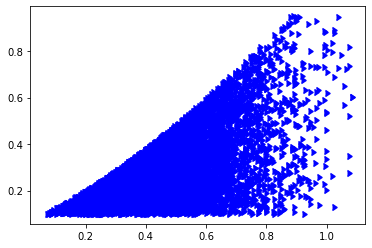

In [772]:
plt.scatter(swings[x_val], swings["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
# plt.plot(x, series_s(x),'k')

In [773]:
swings['threshold'].min()

0.06682047026673703

In [774]:
x = np.arange(0.24, 0.8, 0.001)
y_s = np.zeros(x.shape)
y_l = np.zeros(x.shape)
for i, n in enumerate(x):
    y_s[i] = swings[((swings['threshold'] > n) & (swings['threshold'] <= n + 0.01))]['roll'].max()
    y_l[i] = looks[((looks['threshold'] > n) & (looks['threshold'] <= n + 0.01))]['roll'].min()

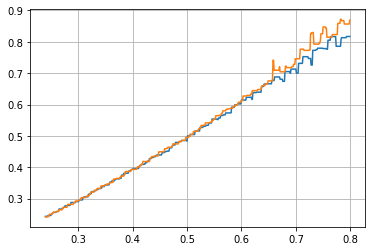

In [775]:
plt.plot(x, y_s)
plt.plot(x, y_l)
plt.grid()

In [776]:
from numpy.polynomial import Polynomial

series_s = Polynomial.fit(x, y_s, 2)
series_l = Polynomial.fit(x, y_l, 2)

In [777]:
print(series_s)
print(series_l)

0.516977282968868 + 0.2996437218285165·x¹ + 0.019685574171296592·x²
0.520052551042309 + 0.31940559375887073·x¹ + 0.040885655777554424·x²


In [778]:
series_s.convert()

Polynomial([0.02804393, 0.81025225, 0.25199067], domain=[-1.,  1.], window=[-1.,  1.])

In [779]:
series_l.convert()

Polynomial([0.06762772, 0.59899536, 0.52336821], domain=[-1.,  1.], window=[-1.,  1.])

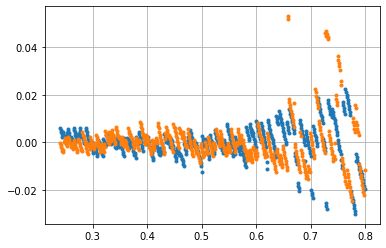

In [780]:
plt.plot(x, y_s - series_s(x), '.')
plt.plot(x, y_l - series_l(x), '.')
plt.grid()

In [781]:
print((series_s.coef + series_l.coef)/2)

[0.51851492 0.30952466 0.03028561]
